# Time Series Forecasting - 

Citibike rentals in New York city.  The bike stations near central park will be selected and the daily number bike trips that orignate from these stations will be followed over time. The data are found in the BigQuery Public datasets at: 
- `bigquery-public-data.new_york.citibike_trips`
- `bigquery-public-data.new_york.citibike_stations`


In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'llm-training-458313'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'forecasting-data'
SERIES = 'applied-forecasting'
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT
viz_limit = 12

packages:

In [3]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

clients:

In [4]:
bq = bigquery.Client(project = PROJECT_ID)

### Create BigQuery Dataset
Create a BigQuery Dataset within this project 

In [5]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
ds.location = 'us'  
ds.labels = {'notebook': f"{EXPERIMENT}"}
ds = bq.create_dataset(dataset = ds, exists_ok = True)

In [6]:
ds.dataset_id

'applied_forecasting'

In [7]:
ds.full_dataset_id

'llm-training-458313:applied_forecasting'

In [8]:
query = f"""
    SELECT * 
    FROM `bigquery-public-data.new_york.citibike_trips`
    LIMIT 5
"""
bq.query(query).to_dataframe()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,1208,2016-08-05 14:18:20+00:00,2016-08-05 14:38:29+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3265,E 2 St & 2 Ave,40.724563,-73.989444,26109,Subscriber,1979,male
1,404,2015-10-30 10:21:47+00:00,2015-10-30 10:28:32+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3234,E 40 St & Madison Ave,40.751594,-73.980432,23033,Subscriber,1991,male
2,640,2015-12-10 17:33:46+00:00,2015-12-10 17:44:27+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3236,PABT Valet,40.758985,-73.993800,17645,Subscriber,1968,male
3,734,2015-12-16 17:31:37+00:00,2015-12-16 17:43:51+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3236,PABT Valet,40.758985,-73.993800,18249,Subscriber,1968,male
4,563,2016-07-12 17:05:50+00:00,2016-07-12 17:15:13+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3236,W 42 St & Dyer Ave,40.758985,-73.993800,20828,Subscriber,1988,male


In [9]:
query = f"""
    SELECT * 
    FROM `bigquery-public-data.new_york.citibike_stations`
    LIMIT 5
"""
bq.query(query).to_dataframe()

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys,last_reported
0,495,W 47 St & 10 Ave,6824.07,40.762699,-73.993012,71,"KEY, CREDITCARD",0,False,0,0,0,0,True,True,True,False,1970-01-02 00:00:00+00:00
1,3171,Amsterdam Ave & W 82 St,7360.10,40.785247,-73.976673,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
2,3603,31 Ave & 30 St,6857.09,40.764700,-73.924031,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
3,3733,Avenue C & E 18 St,5769.04,40.730563,-73.973984,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
4,3792,Columbus Dr at Exchange Pl,JC106,40.716870,-74.032810,70,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00


Review miss-matches in station names between the two source tables:

You FULL JOIN the two lists STATIONS and TRIPS:

    A FULL JOIN means it keeps all records from both sides:

        If a station name exists in STATIONS but not in TRIPS, it still appears (with NULL for trips).

        If a trip start name exists in TRIPS but not in STATIONS, it still appears (with NULL for stations).

    If a match exists (same name in both), you see it lined up.

In [10]:
query = """
    WITH
        STATIONS AS (
            SELECT distinct name as stations
            FROM `bigquery-public-data.new_york.citibike_stations`
            WHERE name LIKE '%Central Park%'
        ),
        TRIPS AS (
            SELECT distinct start_station_name as trips
            FROM `bigquery-public-data.new_york.citibike_trips`
            WHERE start_station_name LIKE '%Central Park%'   
        )
    SELECT *
    FROM STATIONS a
    FULL JOIN TRIPS b
    on a.stations = b.trips
"""
bq.query(query).to_dataframe()

,stations,trips
0,Central Park W & W 97 St,None
1,W 106 St & Central Park West,W 106 St & Central Park West
2,W 82 St & Central Park West,W 82 St & Central Park West
3,Central Park W & W 91 St,None
4,Central Park North & Adam Clayton Powell Blvd,Central Park North & Adam Clayton Powell Blvd
5,7 Ave & Central Park South,None
6,Central Park West & W 72 St,Central Park West & W 72 St
7,None,Central Park West & W 102 St
8,Central Park W & W 103 St,None
9,Central Park West & W 85 St,Central Park West & W 85 St


### Create a Source Table or View
combine multiple sources together to bring together all the data needed for forecasting.   

In [11]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
WITH
    STATION AS (
        SELECT
           start_station_name,
           EXTRACT(DATE FROM starttime) AS starttime,
           COUNT(*) AS num_trips,
           AVG(tripduration) as avg_tripduration,
           COUNTIF(usertype='Subscriber')/COUNT(*) as pct_subscriber,
           SAFE_DIVIDE(COUNTIF(gender='male'), COUNTIF(gender!='male')) as ratio_gender
        FROM `bigquery-public-data.new_york.citibike_trips`
        WHERE start_station_name LIKE '%Central Park%'
        GROUP BY start_station_name, starttime
    ),
    STATION_INFO AS (
        SELECT
            name,
            max(capacity) as capacity
        FROM `bigquery-public-data.new_york.citibike_stations`
        WHERE name LIKE '%Central Park%'
        GROUP BY name
    )
SELECT * EXCEPT(name)
FROM STATION A
LEFT OUTER JOIN STATION_INFO B
ON A.start_station_name = B.name
ORDER BY start_station_name, starttime
"""
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

3.804

Group by station and date (start_station_name, starttime).

For each station-date:

    Count the number of trips (num_trips).

    Compute the average trip duration (avg_tripduration).

    Compute the percentage of trips by subscribers (pct_subscriber).

    Compute the ratio of male to non-male trips (ratio_gender):

        If there are no non-male trips, SAFE_DIVIDE prevents division by zero.

In [12]:
print(f'Review The Source Data in The BigQuery Console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!4m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}_source&pli=1')

Review The Source Data in The BigQuery Console:
https://console.cloud.google.com/bigquery?project=llm-training-458313&ws=!1m5!1m4!4m3!1sllm-training-458313!2sapplied_forecasting!3sforecasting-data_source&pli=1


In [13]:
query = f"""
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
overview = bq.query(query).to_dataframe()
overview.head(viz_limit)

,start_station_name,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity
0,Central Park North & Adam Clayton Powell Blvd,2016-09-01,14,2601.428571,0.214286,0.272727,36
1,Central Park North & Adam Clayton Powell Blvd,2016-09-02,151,1700.635762,0.324503,0.336283,36
2,Central Park North & Adam Clayton Powell Blvd,2016-09-03,255,1902.439216,0.203922,0.214286,36
3,Central Park North & Adam Clayton Powell Blvd,2016-09-04,328,1858.871951,0.213415,0.228464,36
4,Central Park North & Adam Clayton Powell Blvd,2016-09-05,259,1721.289575,0.339768,0.328205,36
5,Central Park North & Adam Clayton Powell Blvd,2016-09-06,96,1468.666667,0.468750,0.655172,36
6,Central Park North & Adam Clayton Powell Blvd,2016-09-07,117,1722.623932,0.512821,0.581081,36
7,Central Park North & Adam Clayton Powell Blvd,2016-09-08,142,1677.795775,0.366197,0.339623,36
8,Central Park North & Adam Clayton Powell Blvd,2016-09-09,129,1693.069767,0.372093,0.343750,36
9,Central Park North & Adam Clayton Powell Blvd,2016-09-10,186,1659.198925,0.327957,0.398496,36


In [14]:
overview.tail(viz_limit)

,start_station_name,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity
4370,W 82 St & Central Park West,2016-09-19,34,968.676471,0.735294,1.266667,45
4371,W 82 St & Central Park West,2016-09-20,62,781.258065,0.887097,1.695652,45
4372,W 82 St & Central Park West,2016-09-21,67,822.761194,0.850746,1.161290,45
4373,W 82 St & Central Park West,2016-09-22,58,907.603448,0.827586,1.900000,45
4374,W 82 St & Central Park West,2016-09-23,117,940.495726,0.743590,1.127273,45
4375,W 82 St & Central Park West,2016-09-24,161,1287.490683,0.664596,1.064103,45
4376,W 82 St & Central Park West,2016-09-25,143,1604.370629,0.545455,0.662791,45
4377,W 82 St & Central Park West,2016-09-26,102,1035.117647,0.617647,0.854545,45
4378,W 82 St & Central Park West,2016-09-27,105,921.800000,0.819048,1.333333,45
4379,W 82 St & Central Park West,2016-09-28,72,769.097222,0.819444,2.130435,45


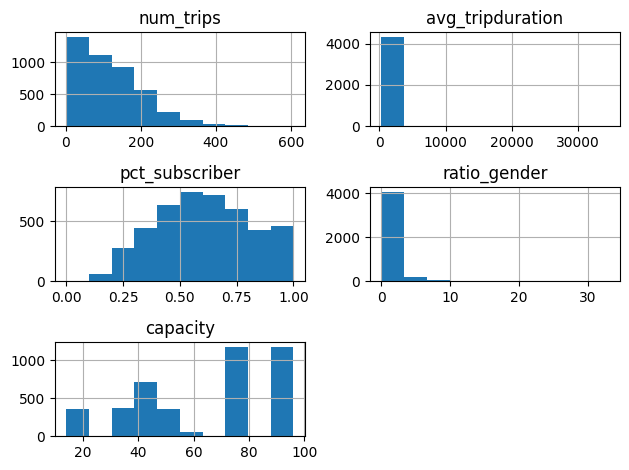

In [15]:
ax = overview.hist()
plt.tight_layout()
plt.show()

### Prepare Data for Forecasting

In [16]:
# CUSTOMIZE THIS CELL
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

Quick Summary of Series with totals and date ranges for each series:

In [17]:
query = f"""
    SELECT {SERIES_COLUMN}, sum({TARGET_COLUMN}) as {TARGET_COLUMN}, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq.query(query).to_dataframe()
overview.head(viz_limit)

,start_station_name,num_trips,FromDate,ToDate
0,Central Park North & Adam Clayton Powell Blvd,4808,2016-09-01,2016-09-30
1,Central Park S & 6 Ave,172220,2013-07-01,2016-09-30
2,Central Park W & W 96 St,5905,2016-08-04,2016-09-30
3,Central Park West & W 100 St,2245,2016-08-08,2016-09-30
4,Central Park West & W 102 St,2851,2016-08-08,2016-09-30
5,Central Park West & W 68 St,35192,2015-09-01,2016-09-30
6,Central Park West & W 72 St,44574,2015-09-01,2016-09-30
7,Central Park West & W 76 St,27919,2015-09-09,2016-09-30
8,Central Park West & W 85 St,43895,2015-10-07,2016-09-23
9,Grand Army Plaza & Central Park S,163815,2013-07-01,2016-09-30


Overlay the dates with data onto the plot to understand any gaps in data (MISSING DATA) for the series:

In [18]:
query = f"""
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
dates = bq.query(query).to_dataframe()

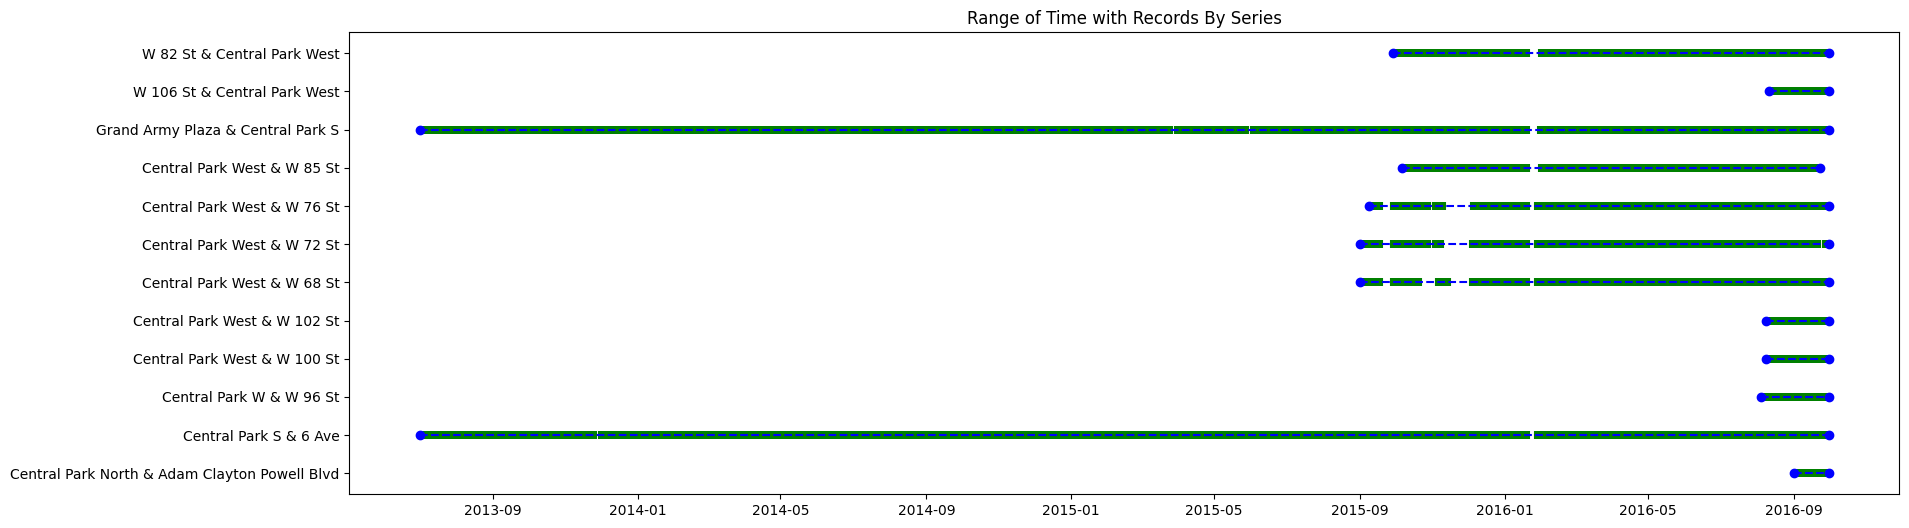

In [19]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    # subset dates to current series and plot dates with records on timelines for each series:
    tempdates = dates[(dates[SERIES_COLUMN] == overview[SERIES_COLUMN][i])]
    plt.scatter(tempdates[TIME_COLUMN], tempdates[SERIES_COLUMN], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

### Propose Train/Validation/Test Splits by Date Range

In [41]:
FORECAST_GRANULARITY = 'DAILY' # the data preparation included preparing the data at this level
FORECAST_HORIZON_LENGTH = 14 # time to forecast following test data
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE

In [21]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {FORECAST_TEST_LENGTH + FORECAST_VALIDATE_LENGTH}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {FORECAST_TEST_LENGTH}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`  
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


Visualize each series date/time range with proposed data segments from key dates:

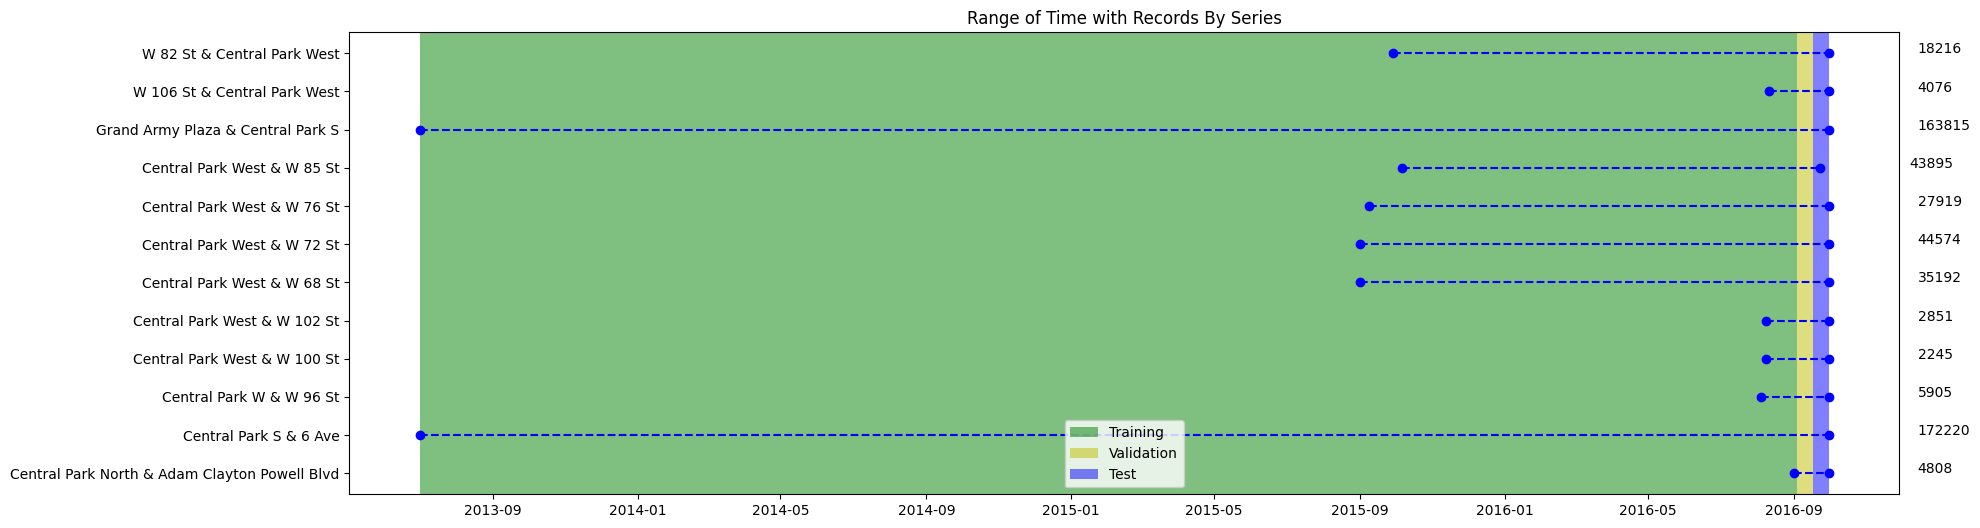

In [22]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

## Create BigQuery Table for Forecasting

In [23]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {FORECAST_TEST_LENGTH} {FORECAST_GRANULARITY}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {FORECAST_TEST_LENGTH} + {FORECAST_VALIDATE_LENGTH} {FORECAST_GRANULARITY}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS {SPLIT_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

1.694

In [24]:
print(f'Review The Prepped Data in The BigQuery Console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!4m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}_prepped&pli=1')

Review The Prepped Data in The BigQuery Console:
https://console.cloud.google.com/bigquery?project=llm-training-458313&ws=!1m5!1m4!4m3!1sllm-training-458313!2sapplied_forecasting!3sforecasting-data_prepped&pli=1


In [25]:
query = f"""
    SELECT 
        *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
"""
bq.query(query).to_dataframe()

,start_station_name,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,splits
0,Central Park North & Adam Clayton Powell Blvd,2016-09-03,255,1902.439216,0.203922,0.214286,36,VALIDATE
1,Central Park North & Adam Clayton Powell Blvd,2016-09-07,117,1722.623932,0.512821,0.581081,36,VALIDATE
2,Central Park S & 6 Ave,2013-09-18,128,1731.031250,0.476562,0.580247,73,TRAIN
3,Central Park S & 6 Ave,2013-09-29,188,2263.388298,0.271277,0.220779,73,TRAIN
4,Central Park S & 6 Ave,2013-11-13,37,854.324324,0.864865,1.642857,73,TRAIN
...,...,...,...,...,...,...,...,...
4377,W 82 St & Central Park West,2016-03-05,17,4541.764706,0.764706,1.125000,45,TRAIN
4378,W 82 St & Central Park West,2016-03-28,13,1042.076923,0.769231,1.166667,45,TRAIN
4379,W 82 St & Central Park West,2016-05-17,67,1139.164179,0.850746,1.481481,45,TRAIN
4380,W 82 St & Central Park West,2016-07-09,80,1395.350000,0.625000,0.818182,45,TRAIN


In [26]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF({SPLIT_COLUMN} = 'TRAIN') as TRAIN,
        COUNTIF({SPLIT_COLUMN} = 'VALIDATE') as VALIDATE,
        COUNTIF({SPLIT_COLUMN} = 'TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq.query(query).to_dataframe()
splitCounts.head(viz_limit)

,start_station_name,TRAIN,VALIDATE,TEST,num_trips
0,Central Park North & Adam Clayton Powell Blvd,2,14,14,4808
1,Central Park S & 6 Ave,1149,14,14,172220
2,Central Park W & W 96 St,30,14,14,5905
3,Central Park West & W 100 St,26,14,14,2245
4,Central Park West & W 102 St,26,14,14,2851
5,Central Park West & W 68 St,331,14,14,35192
6,Central Park West & W 72 St,334,14,13,44574
7,Central Park West & W 76 St,327,14,14,27919
8,Central Park West & W 85 St,324,14,7,43895
9,Grand Army Plaza & Central Park S,1152,14,13,163815


Totals by data split:

In [27]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       4055
VALIDATE     168
TEST         159
dtype: Int64

Overall total:

Visualize days of data available for forecasting at each series:

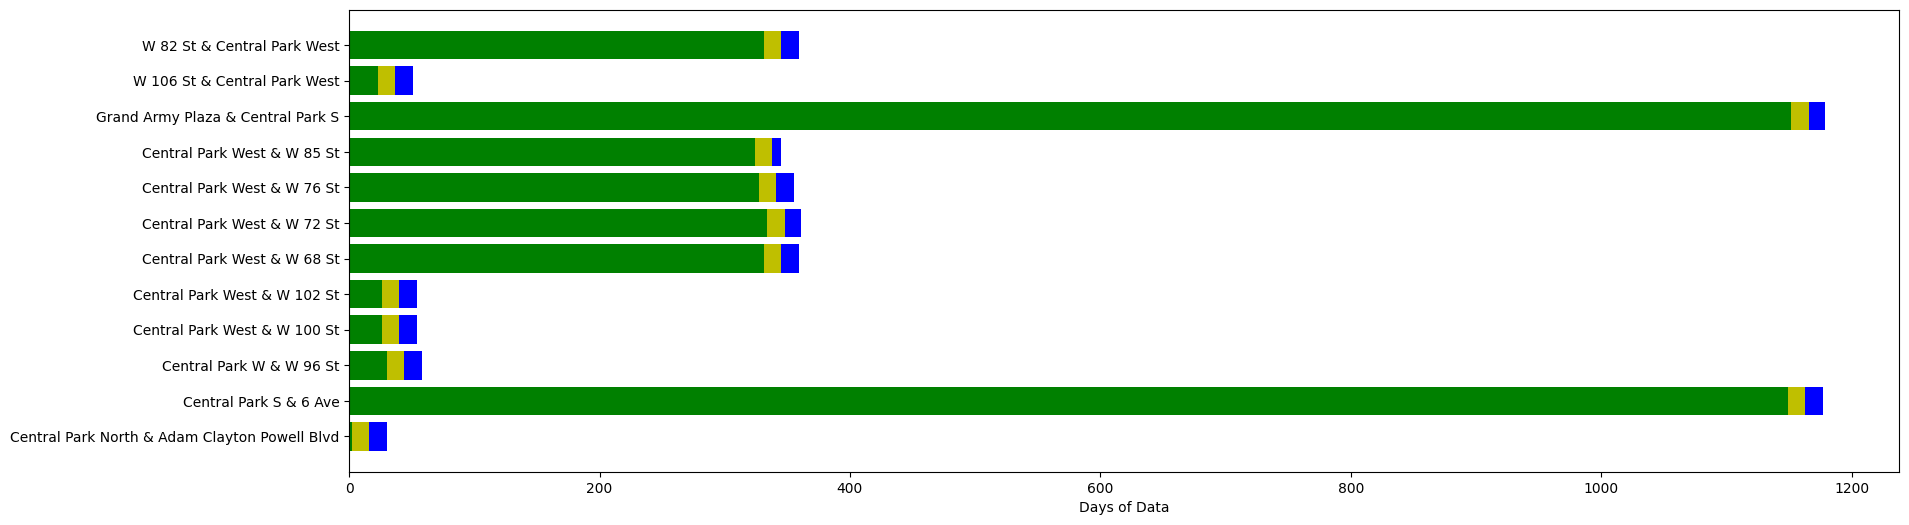

In [28]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

## Duplicate Dates in Series?

In [29]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq.query(query).to_dataframe()

,start_station_name,starttime,records


## forecasting method: model_type = 'ARIMA_PLUS_XREG' = Use ARIMA with external features (XREG)

In [30]:
EXPERIMENT = 'bqml-arimaplusxreg'
BQ_TABLE = 'forecasting-data_prepped'

In [31]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY {SPLIT_COLUMN}
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates



,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


In [32]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, {SPLIT_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()


# chosen station only

In [33]:
chosen_station = 'Central Park S & 6 Ave'
rawSeries = rawSeries[rawSeries[SERIES_COLUMN]==chosen_station]
rawSeries.head()

,start_station_name,starttime,num_trips,splits,avg_tripduration,pct_subscriber,ratio_gender,capacity
30,Central Park S & 6 Ave,2013-07-01,69,TRAIN,1532.144928,0.652174,1.464286,73
31,Central Park S & 6 Ave,2013-07-02,180,TRAIN,1817.505556,0.327778,0.363636,73
32,Central Park S & 6 Ave,2013-07-03,115,TRAIN,1615.504348,0.400000,0.455696,73
33,Central Park S & 6 Ave,2013-07-04,175,TRAIN,2225.331429,0.297143,0.241135,73
34,Central Park S & 6 Ave,2013-07-05,195,TRAIN,2213.061538,0.215385,0.203704,73


In [42]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}',
       #time_series_id_col = '{SERIES_COLUMN}',
       data_frequency = '{FORECAST_GRANULARITY}',
       auto_arima_max_order = 5,
       holiday_region = ['GLOBAL', 'US'],
       horizon = {FORECAST_HORIZON_LENGTH} + {FORECAST_TEST_LENGTH}
      ) AS
    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE {SPLIT_COLUMN} in ('TRAIN','VALIDATE')
        AND {SERIES_COLUMN} = '{chosen_station}'
"""
print(query)



    CREATE OR REPLACE MODEL `llm-training-458313.applied_forecasting.forecasting-data_prepped_arimaplusxreg`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = 'starttime',
       time_series_data_col = 'num_trips',
       #time_series_id_col = 'start_station_name',
       data_frequency = 'DAILY',
       auto_arima_max_order = 5,
       holiday_region = ['GLOBAL', 'US'],
       horizon = 14 + 14
      ) AS
    SELECT starttime, num_trips,
        avg_tripduration, pct_subscriber, ratio_gender, capacity
    FROM `llm-training-458313.applied_forecasting.forecasting-data_prepped`
    WHERE splits in ('TRAIN','VALIDATE')
        AND start_station_name = 'Central Park S & 6 Ave'



In [43]:
job = bq.query(query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 21.535


## Model results:

In [44]:
query = f"""
    SELECT *
    FROM ML.ARIMA_COEFFICIENTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
coefficients = bq.query(query).to_dataframe()
coefficients


,ar_coefficients,ma_coefficients,intercept_or_drift,processed_input,weight,category_weights
0,[],"[-0.6854697029055419, -0.41294316673808423, 0....",0.087807,None,NaN,[]
1,[],[],NaN,avg_tripduration,-0.001514,[]
2,[],[],NaN,pct_subscriber,-302.167414,[]
3,[],[],NaN,ratio_gender,2.385852,[]
4,[],[],NaN,capacity,24.274416,[]
5,[],[],NaN,__INTERCEPT__,-1650.604043,[]


In [45]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
featureInfo = bq.query(query).to_dataframe()
featureInfo.head()


,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,num_trips,1.000,555.000000,144.153912,128.000000,112.409702,<NA>,0,<NA>
1,starttime,NaN,NaN,NaN,NaN,NaN,1163,0,<NA>
2,avg_tripduration,336.625,34597.615385,1918.560216,1830.688406,1334.905339,<NA>,0,<NA>
3,pct_subscriber,0.000,1.000000,0.497785,0.465409,0.214707,<NA>,0,<NA>
4,ratio_gender,0.000,14.000000,0.908012,0.563107,1.329083,<NA>,26,<NA>


In [46]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
trainingInfo = bq.query(query).to_dataframe()
trainingInfo.head()

,training_run,iteration,duration_ms
0,0,0,1925


## evaluating your trained ARIMA+XREG model on the TEST data for the chosen station.


Forecast Metrics

Reference for ML.EVALUATE for model_type = 'ARIMA_PLUS_XREG'

The metrics returned depend on if input (test) data is provided and if perform_aggregation is True or False. If False then metrics per timestamp are provide, and if True then metrics per time_series_id_col are provided.

In [47]:
query = f"""
    SELECT *
    FROM ML.EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
                AND {SERIES_COLUMN} = '{chosen_station}'
        ),
        STRUCT(TRUE AS perform_aggregation))
"""
metrics = bq.query(query).to_dataframe()
metrics


,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
0,83.819373,12656.420894,112.50076,36.418127,31.200138


### ML.ARIMA_EVALUATE gives you detailed diagnostics about the ARIMA model BigQuery ML fitted.

A model metrics table: ARIMA terms:

    p = how many autoregressive terms
    d = how many nonseasonal differences needed for stationarity
    q = number of lagged forecast errors (moving average part)


In [48]:
query = f"""
    SELECT *
    FROM ML.ARIMA_EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT(FALSE as show_all_candidate_models))
"""
arima_metrics = bq.query(query).to_dataframe()
arima_metrics

,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,0,1,5,True,-5781.125974,11576.251948,1109.291723,"[WEEKLY, YEARLY]",True,True,False,


A list of holidays being modeled and have detected holiday effects:

    region, these were specified in the CREATE MODEL statement with parameter holiday_region
    holiday_name is the name of the holiday with detect effect
    primary_date is the calender date of the holiday
    preholiday_days and postholiday_days are the integer window around the holiday taken into account during modeling


In [49]:
query = f"""
    SELECT *
    FROM ML.HOLIDAY_INFO(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`)
"""
holiday_info = bq.query(query).to_dataframe()
holiday_info


,region,holiday_name,primary_date,preholiday_days,postholiday_days
0,GLOBAL,AllSaintsDay-Halloween,2000-10-31,1,1
1,GLOBAL,AllSaintsDay-Halloween,2001-10-31,1,1
2,GLOBAL,AllSaintsDay-Halloween,2002-10-31,1,1
3,GLOBAL,AllSaintsDay-Halloween,2003-10-31,1,1
4,GLOBAL,AllSaintsDay-Halloween,2004-10-31,1,1
...,...,...,...,...,...
1901,US,VeteranDay,2026-11-11,1,1
1902,US,VeteranDay,2027-11-11,1,1
1903,US,VeteranDay,2028-11-11,1,1
1904,US,VeteranDay,2029-11-11,1,1


# Forecast Time Series on horizon

ML.FORECAST predicts future values using your trained model.

Calculates the forecasted value per timestamp and provides standard error and prediction intervals at the requested confidence level. The default horizon is 3 so this parameter may need to be set to the size used at training.

You specify:

    horizon → how many steps into the future (ex: 14 days).

    confidence_level → how sure you want the prediction intervals to be (95% = pretty standard).

You also pass covariates (XREGs) for the prediction period.

In [51]:
query = f"""
    SELECT *
    FROM ML.FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
                AND {SERIES_COLUMN} = '{chosen_station}'
        )
        )
"""
forecast = bq.query(query).to_dataframe()
forecast

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound
0,2016-09-17 00:00:00+00:00,359.138350,33.306036,0.95,293.976487,424.300213
1,2016-09-18 00:00:00+00:00,492.460709,34.914662,0.95,424.151636,560.769782
2,2016-09-19 00:00:00+00:00,333.378266,35.068180,0.95,264.768843,401.987690
3,2016-09-20 00:00:00+00:00,166.394233,40.446282,0.95,87.262777,245.525689
4,2016-09-21 00:00:00+00:00,250.615028,48.305298,0.95,156.107736,345.122319
5,2016-09-22 00:00:00+00:00,262.889067,48.350984,0.95,168.292393,357.485741
6,2016-09-23 00:00:00+00:00,280.596682,48.396627,0.95,185.910711,375.282654
7,2016-09-24 00:00:00+00:00,326.343761,48.442226,0.95,231.568576,421.118946
8,2016-09-25 00:00:00+00:00,383.305900,48.487783,0.95,288.441585,478.170215
9,2016-09-26 00:00:00+00:00,306.608276,48.533297,0.95,211.654915,401.561637


Forecast + Explanations for Time Series

ML.EXPLAIN_FORECAST: enhanced forecasting function that also includes explaination information.

In addition to forecast and the accompanying prediction intervals, this also includes the actual value and information for trend, seasonality, holiday effects, spikes and dips, step changes, and attributions for the external regressors.

In [52]:
query = f"""
    SELECT '{chosen_station}' as {SERIES_COLUMN}, *, 
        EXTRACT(DATE FROM time_series_timestamp) AS {TIME_COLUMN}
    FROM ML.EXPLAIN_FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
        STRUCT({FORECAST_HORIZON_LENGTH + FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SERIES_COLUMN} = '{chosen_station}'
        )
        )
    ORDER BY {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()
explain.tail()


,start_station_name,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,...,holiday_effect_Halloween,holiday_effect_MardiGras,holiday_effect_US_ColumbusDay,holiday_effect_US_ElectionDay,attribution_avg_tripduration,attribution_pct_subscriber,attribution_ratio_gender,attribution_capacity,attribution___INTERCEPT__,starttime
1197,Central Park S & 6 Ave,2016-10-10 00:00:00+00:00,forecast,342.861637,342.861637,49.166068,0.95,246.670286,439.052988,273.396234,...,0.0,0.0,0.0,0.0,-2.904546,-150.414332,2.166382,1772.032385,-1650.604043,2016-10-10
1198,Central Park S & 6 Ave,2016-10-11 00:00:00+00:00,forecast,324.556205,324.556205,49.210954,0.95,228.277036,420.835375,273.484041,...,0.0,0.0,0.0,0.0,-2.904546,-150.414332,2.166382,1772.032385,-1650.604043,2016-10-11
1199,Central Park S & 6 Ave,2016-10-12 00:00:00+00:00,forecast,280.737998,280.737998,49.255800,0.95,184.371090,377.104907,273.571848,...,0.0,0.0,0.0,0.0,-2.904546,-150.414332,2.166382,1772.032385,-1650.604043,2016-10-12
1200,Central Park S & 6 Ave,2016-10-13 00:00:00+00:00,forecast,233.480627,233.480627,49.300605,0.95,137.026060,329.935194,273.659656,...,0.0,0.0,0.0,0.0,-2.904546,-150.414332,2.166382,1772.032385,-1650.604043,2016-10-13
1201,Central Park S & 6 Ave,2016-10-14 00:00:00+00:00,forecast,274.245786,274.245786,49.345369,0.95,177.703640,370.787933,273.747463,...,0.0,0.0,0.0,0.0,-2.904546,-150.414332,2.166382,1772.032385,-1650.604043,2016-10-14


In [54]:
# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast prediction funnel to test and horizon: lower
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    name = f'Lower Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast prediction funnel to test and horizon: upper
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    name = f'Upper Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    fillcolor = 'rgba(0,128,0,0.5)',
                    fill = 'tonexty',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    name = f'Forecast: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 3 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
#fig.show()

### Custom Evaluation Metrics

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

It can be helpful to explicity calculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

>```sql
>(actual_value - forecast_value) as diff
>
>
>AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
>AVG(ABS(diff)) as MAE,
>SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
>AVG(POW(diff, 2)) as MSE,
>SQRT(AVG(POW(diff, 2))) as RMSE,
>SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
>```

In [55]:
query = f"""
    WITH    
        FORECAST AS (
            SELECT
                '{chosen_station}' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
                STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
                    WHERE {SPLIT_COLUMN} = 'TEST'
                        AND {SERIES_COLUMN} = '{chosen_station}'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST' AND {SERIES_COLUMN} = '{chosen_station}'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT {SERIES_COLUMN}, time_series_type, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}, time_series_type
    ORDER BY {SERIES_COLUMN}, time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics.head(viz_limit)


,start_station_name,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,Central Park S & 6 Ave,forecast,0.364181,83.819373,0.256833,12656.420894,112.50076,0.344717


### Overall Metrics

In [56]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                '{chosen_station}' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg`,
                STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
                    WHERE splits = 'TEST'
                        AND {SERIES_COLUMN} = '{chosen_station}'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT time_series_type, 
        AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
        AVG(ABS(diff)) as MAE,
        SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
        AVG(POW(diff, 2)) as MSE,
        SQRT(AVG(POW(diff, 2))) as RMSE,
        SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY time_series_type
    ORDER BY time_series_type    
"""
customMetricsOverall = bq.query(query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,forecast,0.364181,83.819373,0.256833,12656.420894,112.50076,0.344717


In [57]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg')
bq.delete_model(model)

# Prophet model and then deploy the model

In [68]:
EXPERIMENT = 'online-prophet'

In [70]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 70.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.9/917.9 kB 19.0 MB/s eta 0:00:00


In [71]:
import os
import json
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from google.cloud import aiplatform
from google.cloud import artifactregistry_v1
from prophet import Prophet
import bigframes.pandas as bf

In [73]:
aiplatform.init(project = PROJECT_ID, location = REGION)
ar_client = artifactregistry_v1.ArtifactRegistryClient()
bf.options.bigquery.project = BQ_PROJECT

In [74]:
df = bf.read_gbq(f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}")

In [75]:
df.head()

,start_station_name,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,splits
0,Central Park S & 6 Ave,2014-11-24,69,1583.086957,0.550725,0.769231,73,TRAIN
1,Central Park S & 6 Ave,2014-06-16,133,1665.511278,0.586466,0.985075,73,TRAIN
2,Central Park S & 6 Ave,2014-05-17,217,1836.308756,0.387097,0.4,73,TRAIN
3,Central Park S & 6 Ave,2016-07-29,156,1248.423077,0.532051,0.793103,73,TRAIN
4,Central Park S & 6 Ave,2013-10-20,254,2204.059055,0.440945,0.403315,73,TRAIN


In [76]:
df.shape

(4382, 8)

In [77]:
df.dtypes

start_station_name         string[pyarrow]
starttime             date32[day][pyarrow]
num_trips                            Int64
avg_tripduration                   Float64
pct_subscriber                     Float64
ratio_gender                       Float64
capacity                             Int64
splits                     string[pyarrow]
dtype: object

In [78]:
stations = df['start_station_name'].unique().tolist()
stations


['Central Park S & 6 Ave',
 'Central Park West & W 76 St',
 'Central Park West & W 102 St',
 'Grand Army Plaza & Central Park S',
 'Central Park West & W 72 St',
 'W 82 St & Central Park West',
 'Central Park West & W 68 St',
 'Central Park W & W 96 St',
 'Central Park West & W 100 St',
 'Central Park West & W 85 St',
 'Central Park North & Adam Clayton Powell Blvd',
 'W 106 St & Central Park West']

In [79]:
df[df['start_station_name'] == stations[0]].sort_values(by = ['starttime'])

,start_station_name,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,splits
797,Central Park S & 6 Ave,2013-07-01,69,1532.144928,0.652174,1.464286,73,TRAIN
2112,Central Park S & 6 Ave,2013-07-02,180,1817.505556,0.327778,0.363636,73,TRAIN
2002,Central Park S & 6 Ave,2013-07-03,115,1615.504348,0.4,0.455696,73,TRAIN
1721,Central Park S & 6 Ave,2013-07-04,175,2225.331429,0.297143,0.241135,73,TRAIN
3954,Central Park S & 6 Ave,2013-07-05,195,2213.061538,0.215385,0.203704,73,TRAIN
2063,Central Park S & 6 Ave,2013-07-06,222,1812.40991,0.18018,0.168421,73,TRAIN
3678,Central Park S & 6 Ave,2013-07-07,266,1942.007519,0.214286,0.1875,73,TRAIN
9,Central Park S & 6 Ave,2013-07-08,143,2368.783217,0.328671,0.361905,73,TRAIN
3707,Central Park S & 6 Ave,2013-07-09,148,1942.959459,0.554054,0.741176,73,TRAIN
707,Central Park S & 6 Ave,2013-07-10,142,1868.626761,0.514085,0.690476,73,TRAIN


In [80]:
ts = df[(df['start_station_name'] == stations[0])][['starttime','num_trips']].rename(columns = {'starttime': 'ds', 'num_trips': 'y'}).sort_values(by = ['ds'])
ts.head()

,ds,y
797,2013-07-01,69
2112,2013-07-02,180
2002,2013-07-03,115
1721,2013-07-04,175
3954,2013-07-05,195


In [81]:
local_ts = ts.to_pandas()

In [82]:
p = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
p.add_country_holidays(country_name='US')
p.fit(local_ts.iloc[0:-10])


19:43:28 - cmdstanpy - INFO - Chain [1] start processing
19:43:28 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
future = p.make_future_dataframe(periods = 14, include_history = False)
future.head()


,ds
0,2016-09-21
1,2016-09-22
2,2016-09-23
3,2016-09-24
4,2016-09-25


In [85]:
forecast = p.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-09-21,205.363609,194.327854,355.276330,205.363609,205.363609,0.0,0.0,0.0,0.0,...,-26.265590,-26.265590,-26.265590,67.612301,67.612301,67.612301,0.0,0.0,0.0,276.215619
1,2016-09-22,205.542889,188.981020,345.111230,205.542889,205.542889,0.0,0.0,0.0,0.0,...,-27.763628,-27.763628,-27.763628,63.322679,63.322679,63.322679,0.0,0.0,0.0,270.607239
2,2016-09-23,205.722169,203.974531,355.226267,205.722169,205.722169,0.0,0.0,0.0,0.0,...,-14.947044,-14.947044,-14.947044,59.042556,59.042556,59.042556,0.0,0.0,0.0,279.322979
3,2016-09-24,205.901449,264.880221,422.932510,205.901449,205.901449,0.0,0.0,0.0,0.0,...,52.391135,52.391135,52.391135,54.832081,54.832081,54.832081,0.0,0.0,0.0,342.629963
4,2016-09-25,206.080729,272.299662,416.059074,206.080729,206.080729,0.0,0.0,0.0,0.0,...,58.735513,58.735513,58.735513,50.748957,50.748957,50.748957,0.0,0.0,0.0,345.070498


# review results

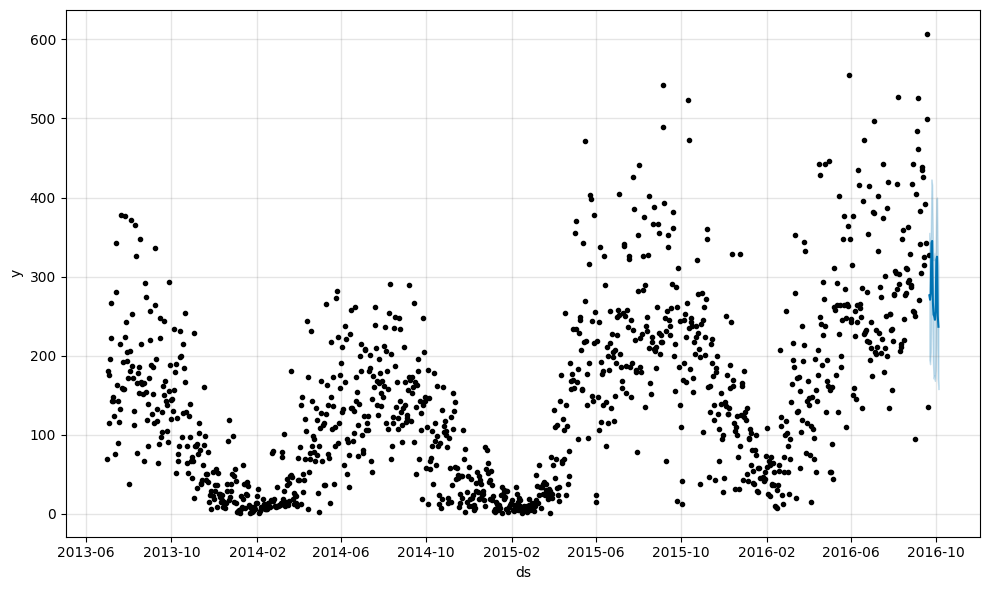

In [86]:
p.plot(forecast);

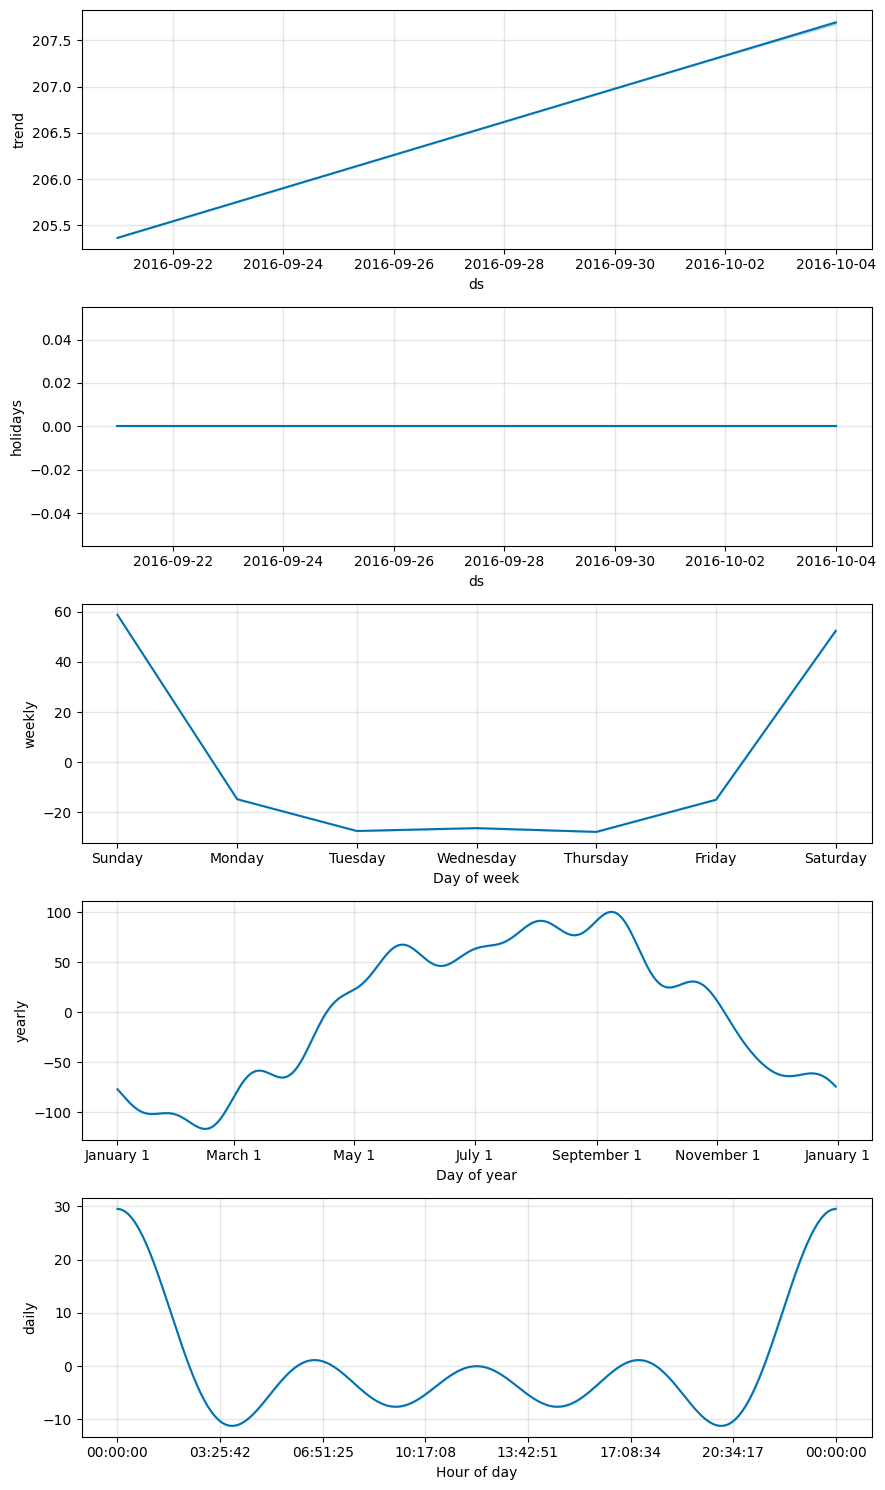

In [87]:
p.plot_components(forecast);

In [88]:
results = local_ts.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].astype(local_ts[['ds']].dtypes.to_dict()), how = 'outer', left_on = 'ds', right_on = 'ds')
results.iloc[-15:]


,ds,y,yhat,yhat_lower,yhat_upper
1166,2016-09-20,327,NaN,NaN,NaN
1167,2016-09-21,403,276.215619,194.327854,355.276330
1168,2016-09-22,351,270.607239,188.981020,345.111230
1169,2016-09-23,354,279.322979,203.974531,355.226267
1170,2016-09-24,399,342.629963,264.880221,422.932510
1171,2016-09-25,402,345.070498,272.299662,416.059074
1172,2016-09-26,312,267.875081,194.736294,348.146693
1173,2016-09-27,264,251.707391,170.878975,320.713268
1174,2016-09-28,234,249.636276,174.652583,328.992691
1175,2016-09-29,222,245.229627,167.932703,322.429316


In [89]:
results.dtypes

ds            date32[day][pyarrow]
y                            Int64
yhat                       float64
yhat_lower                 float64
yhat_upper                 float64
dtype: object

(array([17053., 17057., 17061., 17065., 17069., 17073., 17075., 17079.]),
 [Text(17053.0, 0, '2016-09-09'),
  Text(17057.0, 0, '2016-09-13'),
  Text(17061.0, 0, '2016-09-17'),
  Text(17065.0, 0, '2016-09-21'),
  Text(17069.0, 0, '2016-09-25'),
  Text(17073.0, 0, '2016-09-29'),
  Text(17075.0, 0, '2016-10-01'),
  Text(17079.0, 0, '2016-10-05')])

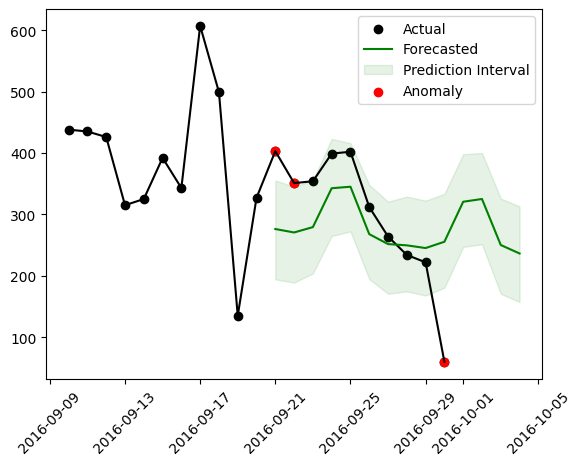

In [94]:
r_results = results[-25:]
fig, ax = plt.subplots()
ax.scatter(r_results['ds'], r_results['y'], color = 'black', label = 'Actual')
ax.plot(r_results['ds'], r_results['y'], color='black')

ax.plot(r_results['ds'], r_results['yhat'], color = 'green', label = 'Forecasted')
ax.fill_between(r_results['ds'], r_results['yhat_lower'], r_results['yhat_upper'], color = 'green', alpha = .1, label = 'Prediction Interval')
anomaly = r_results[(r_results['y'] < r_results['yhat_lower']) | (r_results['y'] > r_results['yhat_upper'])]
ax.scatter(anomaly['ds'], anomaly['y'], color = 'red', label = 'Anomaly')

ax.legend(loc='best')
plt.xticks(rotation=45)
